<a href="https://colab.research.google.com/github/datasiyeon/Python_Fraud_Prediction_Model/blob/main/Fraud_Prediction_Model_CreateVariable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import io

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/2022유통판매데이터분석수업/

/content/drive/My Drive/2022유통판매데이터분석수업


In [4]:
data = pd.read_csv('Fraud_Data.csv') # Fraud_Data.csv 데이터 불러오기

In [5]:
# The week of the year
data['s_week'] = pd.to_datetime(data['signup_time']).dt.isocalendar().week # signup_time 주 정보 뽑아내서 s_week로 저장
data['p_week'] = pd.to_datetime(data['purchase_time']).dt.isocalendar().week # purchase_time 주 정보 뽑아내서 p_week로 저장

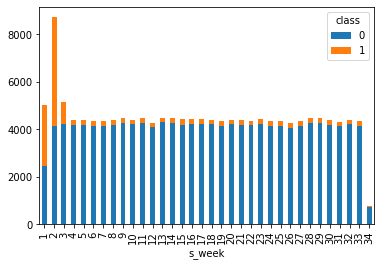

In [17]:
data.groupby(['s_week', 'class']).size().unstack().plot.bar(stacked=True) ### 계정 개설 시간 1월 1,2,3주에 사기거래(1)가 몰려있음.

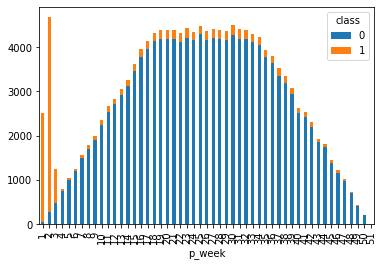

In [18]:
data.groupby(['p_week', 'class']).size().unstack().plot.bar(stacked=True) ### 상품 첫 구매시간 1월 1,2,3주에 사기거래(1)가 몰려있음.

In [20]:
# check the difference between the two dates (dt = purchase_time - signup_time)
data['dt'] = (pd.to_datetime(data['purchase_time']) - pd.to_datetime(data['signup_time'])).astype('timedelta64[D]') # dt(가입한 시간에서 구매하는 시점 뺀) 정보 뽑아내기

class
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: dt, dtype: object

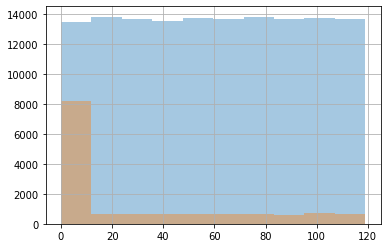

In [21]:
data.groupby("class").dt.hist(alpha=0.4) # dt(가입한 시간에서 구매하는 시점 뺀) 기간이 짧을수록 사기거래가 많이 이뤄짐.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


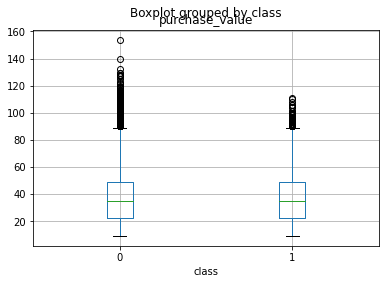

In [22]:
# purchase_value
data.boxplot(by='class', column=['purchase_value'], grid=True) ### 상품 구매가격이 높으면 의심을 살 수 있으므로 평균 구매가격으로 사기 거래가 이뤄짐.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


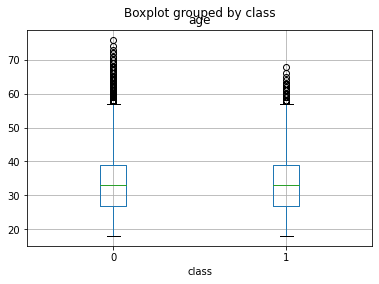

In [23]:
# age
data.boxplot(by='class', column=['age'], grid=True) ### 나이도 마찬가지로 너무 많으면 의심을 살 수 있으므로 평균 나이대로 사기 거래가 이뤄짐.

In [19]:
device_count = data[['user_id', 'device_id']].groupby('device_id').count().reset_index() # device_count라는 새로운 데이터 프레임 만들기

In [10]:
device_count = device_count.rename(columns={'user_id': 'd_ct'}) # d_ct로 이름 바꾸기

In [11]:
data = data.merge(device_count, how='left', on='device_id') # data와 device_count 결합 시키기(left 조인)

In [27]:
t1= data.groupby(['class', 'd_ct']).size().to_frame('size').reset_index().sort_values(['class', 'd_ct'], ascending=False)
t1.pivot_table(index='d_ct', columns='class', values='size').sort_values(('d_ct'), ascending=False) ### 사기 거래일수록 기기를 공유함.

class,0,1
d_ct,,
20,6,114
19,5,90
18,11,169
17,14,207
16,38,538
15,47,568
14,58,740
13,65,767
12,88,992


In [12]:
ip_count = data[['user_id', 'ip_address']].groupby('ip_address').count().reset_index() # ip_count 데이터프레임 만들기
ip_count = ip_count.rename(columns={'user_id': 'ip_ct'}) # ip_ct로 이름 바꾸기
data = data.merge(ip_count, how='left', on='ip_address') # data와 ip_count 결합 시키기(left 조인)

In [25]:
t2= data.groupby(['class', 'ip_ct']).size().to_frame('size').reset_index().sort_values(['class', 'ip_ct'], ascending=False)
t2.pivot_table(index='ip_ct', columns='class', values='size').sort_values(('ip_ct'), ascending=False) ### 사기 거래일수록 ip 주소를 공유함.

class,0,1
ip_ct,,
20,4,76
19,6,127
18,9,153
17,12,192
16,35,541
15,36,504
14,56,770
13,60,772
12,87,1005


In [15]:
ip = pd.read_csv('IpAddress_to_Country.csv') # IpAddress_to_Country.csv 불러와서 ip로 저장

In [16]:
#IP address to country mapping  ## IP 주소 mapping하기
countries = []
for i in range(len(data)):      ## 
  ip_address = data.loc[i, 'ip_address']
  tmp = ip[(ip['lower_bound_ip_address'] <= ip_address) &
                        (ip['upper_bound_ip_address'] >= ip_address)]
  if len(tmp) == 1:
    countries.append(tmp['country'].values[0])
  else:
    countries.append('NA')

data['country'] = countries